Importing the Required Libraries

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

Loading the Dataset

In [131]:
df = pd.read_csv(r"C:\Users\spywa\Python_Project\cariad-connected-usage-intel\data\connected_vehicle_usage_unclean.csv")
df.info(); df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52000 entries, 0 to 51999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               52000 non-null  object 
 1   region                49051 non-null  object 
 2   vehicle_model         51910 non-null  object 
 3   feature_name          50517 non-null  object 
 4   session_duration_min  49230 non-null  float64
 5   error_flag            52000 non-null  int64  
 6   feedback_rating       49721 non-null  object 
 7   app_version           50478 non-null  object 
 8   os_type               52000 non-null  object 
 9   subscription_status   50194 non-null  object 
 10  feature_used_at       51745 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.4+ MB


,user_id,region,vehicle_model,feature_name,session_duration_min,error_flag,feedback_rating,app_version,os_type,subscription_status,feature_used_at
0,U01101,Spain,Škoda Enyaq,Lock/Unlock,11.32,1,5.0,v5.5,iOS,active,2025-09-17 23:04:01.205001
1,U00567,Germany,Audi e-tron,NaN,0.37,0,4.0,v3.8,Android,active,2025-08-20 05:32:01.205001
2,U00149,UK,Porsche Taycan,Navigation,0.95,0,4.0,v4.2,Android,active,2025-08-21 01:24:01.205001
3,U00155,UK,Škoda Enyaq,Trip History,0.75,0,2.0,v1.7,Android,active,2025-09-10 18:39:01.205001
4,U00489,UK,VW Golf,Trip History,NaN,0,3.0,v5.8,Android,active,2025-07-19 09:16:01.205001


EDA

In [132]:
df.isna().sum()
df.describe(include='all')
df.duplicated().sum()

np.int64(843)

Cleaning the Data

Fixing the text columns

In [133]:
def normalize_str(s):
    if pd.isna(s): return s
    s = str(s).strip()
    s = " ".join(s.split())
    return s.title()

for col in ["region","feature_name","os_type","subscription_status","vehicle_model","app_version"]:
    df[col] = df[col].apply(normalize_str)

Standardizing categories

In [134]:
# OS
df["os_type"] = df["os_type"].str.lower().map({
    "android": "Android", "a n d r o i d": "Android",
    "ios": "iOS", "  ios": "iOS", "ios ": "iOS",
    "winphone": "Other", "unknown": "Other"
}).fillna(df["os_type"])

# Subscription
df["subscription_status"] = df["subscription_status"].str.lower().str.strip().map({
    "active":"active"," inactive":"inactive","inactive":"inactive","":np.nan,
    "trial":"trial"
}).fillna(df["subscription_status"])


Coerce types & handling Data outliers

In [135]:
df["session_duration_min"] = pd.to_numeric(df["session_duration_min"], errors="coerce")
df.loc[df["session_duration_min"] <= 0, "session_duration_min"] = np.nan
upper = df["session_duration_min"].quantile(0.99)
df["session_duration_min"] = df["session_duration_min"].clip(upper=upper)
df["feedback_rating"] = pd.to_numeric(df["feedback_rating"], errors="coerce").clip(1,5)

Parsing timestamps & droping invalids

In [136]:
df["feature_used_at"] = pd.to_datetime(df["feature_used_at"], errors="coerce", utc=True)

Fixing app_version patterns

In [137]:
def to_semver(v):
    if pd.isna(v): return v
    v = str(v).strip().lower()
    m = re.search(r"(\d+)[\._-]?(\d+)", v)
    if m:
        return f"v{m.group(1)}.{m.group(2)}"
    return np.nan

df["app_version"] = df["app_version"].apply(to_semver)


Unifing vehicle models

In [138]:
norm_map = {
    "vw-id4":"VW ID.4", "vw id.4":"VW ID.4", "vw golf":"VW Golf",
    "audi  e-tron":"Audi e-tron", "skodaenyaq":"Škoda Enyaq", "unknown":np.nan, "na":np.nan
}
df["vehicle_model_norm"] = (
    df["vehicle_model"].str.lower().str.replace(".", "", regex=False).str.replace("-", "", regex=False).str.replace("  ", " ")
)
df["vehicle_model"] = df["vehicle_model_norm"].replace(norm_map).fillna(df["vehicle_model"])
df.drop(columns=["vehicle_model_norm"], inplace=True)

Droping the duplicates & deciding missing-value policy

In [139]:
df = df.drop_duplicates()
critical = ["user_id","feature_name","feature_used_at"]
df = df.dropna(subset=critical)

Creating derived columns

In [140]:
df["date"] = df["feature_used_at"].dt.date
df["week"] = df["feature_used_at"].dt.isocalendar().week

Identifying the Missing Values

In [141]:
missing_summary = df.isna().sum().sort_values(ascending=False)
missing_percent = (df.isna().mean()*100).round(2).sort_values(ascending=False)
print(pd.concat([missing_summary, missing_percent], axis=1, keys=['Missing', '%']))

                      Missing     %
session_duration_min     3659  7.47
region                   2837  5.79
feedback_rating          2239  4.57
app_version              1878  3.83
subscription_status      1737  3.55
vehicle_model              85  0.17
user_id                     0  0.00
feature_name                0  0.00
error_flag                  0  0.00
os_type                     0  0.00
feature_used_at             0  0.00
date                        0  0.00
week                        0  0.00


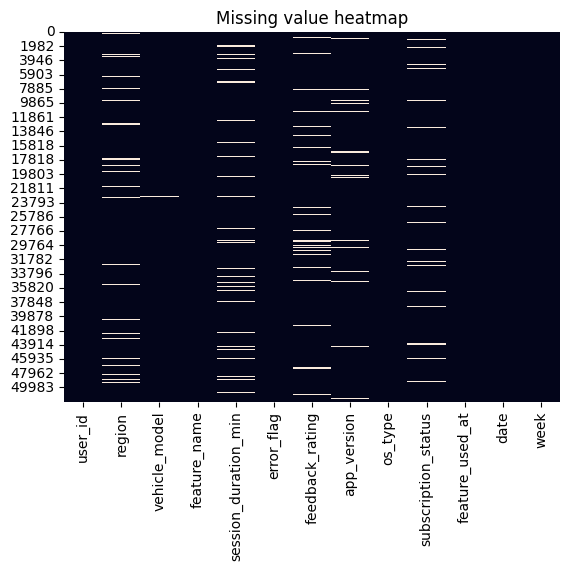

In [142]:
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing value heatmap")
plt.show()

Implementing efficient imputations

Handling Numeric Imputations

In [ ]:
df["session_duration_min"] = df.groupby("feature_name")["session_duration_min"] \
                                .transform(lambda x: x.fillna(x.median()))
df["feedback_rating"] = df.groupby("region")["feedback_rating"] \
                          .transform(lambda x: x.fillna(x.median()))

for col in ["session_duration_min", "feedback_rating"]:
    df[col] = df[col].fillna(df[col].median())

Handling Categorical Imputations


In [ ]:
cat_cols = ["region","vehicle_model","feature_name","app_version","os_type","subscription_status"]
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "Unknown")

Handling Date-Time Imputations

In [ ]:
df["feature_used_at"] = pd.to_datetime(df["feature_used_at"], errors="coerce")
df = df.sort_values(["user_id", "feature_used_at"])

df["feature_used_at"] = df.groupby("user_id")["feature_used_at"].bfill()
df["feature_used_at"] = df["feature_used_at"].fillna(df["feature_used_at"].median())

In [ ]:
print(df.isna().sum())
assert df.isna().sum().sum() == 0, "Checking if still some missing values left!"

user_id                 0
region                  0
vehicle_model           0
feature_name            0
session_duration_min    0
error_flag              0
feedback_rating         0
app_version             0
os_type                 0
subscription_status     0
feature_used_at         0
date                    0
week                    0
dtype: int64


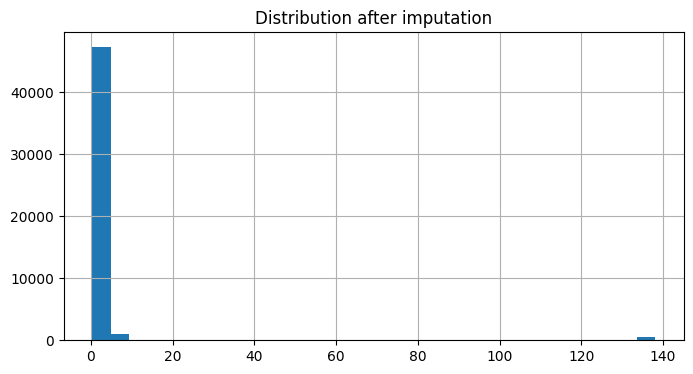

In [147]:
plt.figure(figsize=(8,4))
df["session_duration_min"].hist(bins=30)
plt.title("Distribution after imputation")
plt.show()

4. Validating the Dataset

In [ ]:
df.isna().sum().sum()
df.isna().sum()

user_id                 0
region                  0
vehicle_model           0
feature_name            0
session_duration_min    0
error_flag              0
feedback_rating         0
app_version             0
os_type                 0
subscription_status     0
feature_used_at         0
date                    0
week                    0
dtype: int64

In [149]:
assert df.isna().sum().sum() < 1000

Exported the cleaned Dataset to Data Path

In [150]:
path = "../data/connected_vehicle_usage_cleaned.csv"
df.to_csv(path, index=False)
print(f"Cleaned dataset saved successfully at: {path}")

Cleaned dataset saved successfully at: ../data/connected_vehicle_usage_cleaned.csv
